<a href="https://colab.research.google.com/github/shubham21221/100daysofcodechallenge/blob/master/Copy_of_Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Predict Diabetes From Medical Records**

Diabetes mellitus (DM), commonly referred to as diabetes, is a group of metabolic disorders in which there are high blood sugar levels over a prolonged period.  Type 1 diabetes results from the pancreas's failure to produce enough insulin.  Type 2 diabetes begins with insulin resistance, a condition in which cells fail to respond to insulin properly.

The [Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database) can be used to train machine learning models to predict if a given patient has diabetes.  

This dataset contains measurements relating to 

1. Pregnancies
2. Glucose
3. BloodPressure
4. SkinThickness
5. Insulin
6. BMI
7. DiabetesPedigreeFunction
8. Age


In [ ]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import graphviz 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#Step 1: Data Pre-Processing

While inspecting the first ten rows of data one thing that jumps out right away is that there are measurements of zero for both insulin levels and skin thickness.  

In [ ]:
dataset = read_csv(r'/content/drive/MyDrive/Sem_5_B2/DMSDAM_CP/diabetes.csv')
dataset_cols = dataset.columns
dataset.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


It would be a serious medical problem if a patient had an insulin level and skin thickness measurement of zero.  

As such, we can conclude that this dataset uses the number zero to represent missing or null data.  


Here we can see that as many as half of the rows contain columns with missing data.

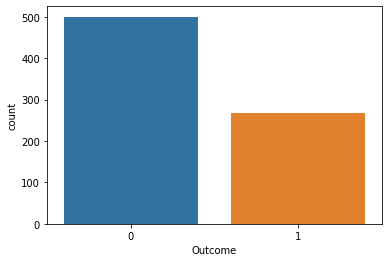

In [ ]:
# Total Diabetic and Non-diabetic patients
sns.countplot(x = 'Outcome',data = dataset)
plt.show()

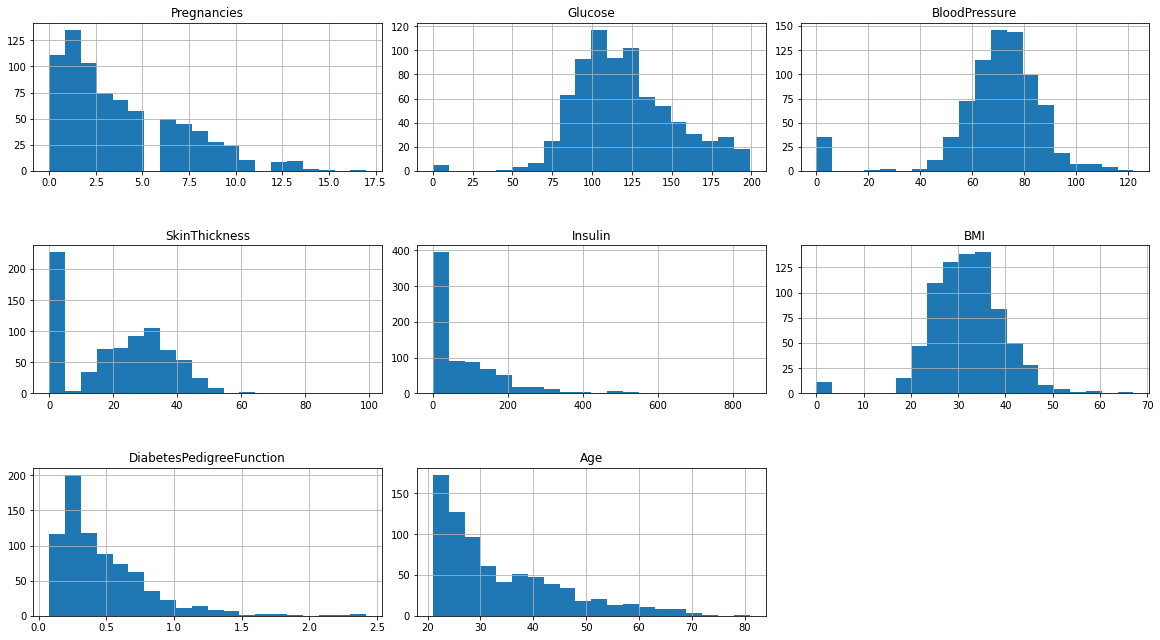

In [ ]:
# Histogram of each feature
col = dataset.columns[:8]
plt.subplots(figsize = (20, 15))
length = len(col)

for i, j in itertools.zip_longest(col, range(length)):
    plt.subplot((length/2), 3, j + 1)
    plt.subplots_adjust(wspace = 0.1,hspace = 0.5)
    dataset[i].hist(bins = 20)
    plt.title(i)
plt.show()

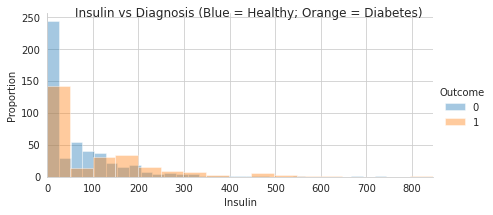

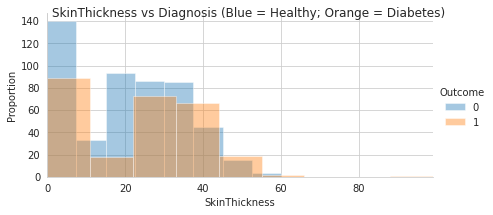

In [ ]:
def plotHistogram(values,label,feature,title):
    sns.set_style("whitegrid")
    plotOne = sns.FacetGrid(values, hue=label,aspect=2)
    plotOne.map(sns.distplot,feature,kde=False)
    plotOne.set(xlim=(0, values[feature].max()))
    plotOne.add_legend()
    plotOne.set_axis_labels(feature, 'Proportion')
    plotOne.fig.suptitle(title)
    plt.show()
plotHistogram(dataset,"Outcome",'Insulin','Insulin vs Diagnosis (Blue = Healthy; Orange = Diabetes)')
plotHistogram(dataset,"Outcome",'SkinThickness','SkinThickness vs Diagnosis (Blue = Healthy; Orange = Diabetes)')

In [ ]:
dataset2 = dataset.iloc[:, :-1]
print("Number of Rows, Number of Columns: ",dataset2.shape)
print("\nColumn Name                Number of Null Values\n")
print((dataset2[:] == 0).sum())

Number of Rows, Number of Columns:  (768, 8)

Column Name                Number of Null Values

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


In [ ]:
print("Number of Rows, Number of Columns: ",dataset2.shape)
print("\nColumn Name                 Number of Null Values\n")
print(((dataset2[:] == 0).sum())/2000*100)

Number of Rows, Number of Columns:  (768, 8)

Column Name                 Number of Null Values

Pregnancies                  5.55
Glucose                      0.25
BloodPressure                1.75
SkinThickness               11.35
Insulin                     18.70
BMI                          0.55
DiabetesPedigreeFunction     0.00
Age                          0.00
dtype: float64


**Approximately 50% of the patients did not have their insulin levels measured**.  This concerns that maybe the doctors only measured insulin levels in unhealthy looking patients -- or maybe they only measured insulin levels after having first made a preliminary diagnosis.  

---

If that were true then this would be a form of [data leakage](https://www.kaggle.com/dansbecker/data-leakage), and it would mean that our model would not generalize well to data collected from doctors who measure insulin levels for every patient.  

---

In order to test this hypothesis We checked whether or not the Insulin and SkinThickness features are correlated with a diagnostic outcome
(healthy/diabetic).  What we find is that these features are not highly correlated with any given outcome -- and as such we can rule out our concern of data leakage.


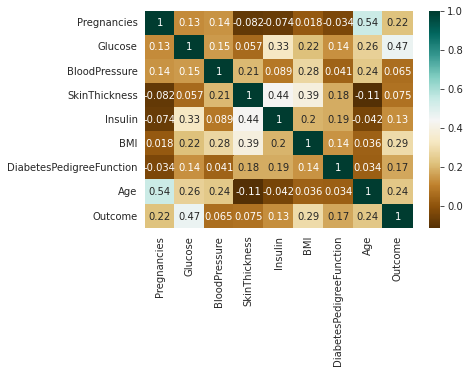

In [ ]:
g = sns.heatmap(dataset.corr(),cmap="BrBG",annot=True)

In [ ]:
dataset.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [ ]:
dataset_new = dataset.iloc[:, :-1].replace(0, np.NaN)

In [ ]:
# Count of NaN
dataset_new.isnull().sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

In [ ]:
dataset_new.fillna(dataset_new.median(), inplace=True)
# Count of NaN
dataset_new.isnull().sum()
dataset_new['Outcome'] = dataset['Outcome']

In [ ]:
dataset_new.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1.0,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8.0,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,4.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
5,5.0,116.0,74.0,29.0,125.0,25.6,0.201,30,0
6,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26,1
7,10.0,115.0,72.0,29.0,125.0,35.3,0.134,29,0
8,2.0,197.0,70.0,45.0,543.0,30.5,0.158,53,1
9,8.0,125.0,96.0,29.0,125.0,32.3,0.232,54,1


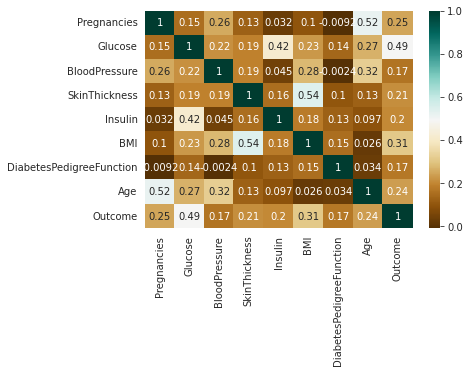

In [ ]:
sns.heatmap(dataset_new.corr(),cmap="BrBG",annot=True)
plt.show()

In [ ]:
dataset_new.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,4.423177,2.980481,1.000,2.00000,4.0000,6.00000,17.00
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.0000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.0000,127.25000,846.00
BMI,768.0,32.455208,6.875177,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [ ]:
duplicate = dataset_new[dataset_new.duplicated()]

In [ ]:
duplicate.shape

(0, 9)

In [ ]:
# Feature scaling using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = sc.fit_transform(dataset_new)

In [ ]:
dataset_scaled = pd.DataFrame(dataset_scaled)

In [ ]:
# Selecting features - [Glucose, Insulin, BMI, Age]
X = dataset_scaled.iloc[:, [1, 4, 5, 7]].values
Y = dataset_scaled.iloc[:, 8].values

In [ ]:
# Splitting X and Y
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42, stratify = dataset_new['Outcome'] )

In [ ]:
# Checking dimensions
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (614, 4)
X_test shape: (154, 4)
Y_train shape: (614,)
Y_test shape: (154,)


#Step 2: Data Modeling

In [ ]:
# Logistic Regression Algorithm
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state = 42)
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

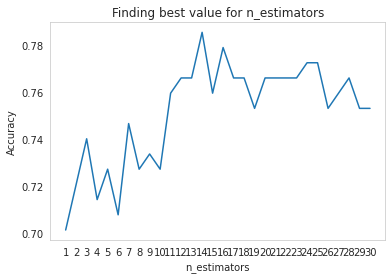

Highest value:  0.7857142857142857


In [ ]:
# Plotting a graph for n_neighbors 
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

X_axis = list(range(1, 31))
acc = pd.Series()
x = range(1,31)

for i in list(range(1, 31)):
    knn_model = KNeighborsClassifier(n_neighbors = i) 
    knn_model.fit(X_train, Y_train)
    prediction = knn_model.predict(X_test)
    acc = acc.append(pd.Series(metrics.accuracy_score(prediction, Y_test)))
plt.plot(X_axis, acc)
plt.xticks(x)
plt.title("Finding best value for n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.grid()
plt.show()
print('Highest value: ',acc.values.max())

In [ ]:
# K nearest neighbors Algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 24, metric = 'minkowski', p = 2)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=24, p=2,
                     weights='uniform')

In [ ]:
# Support Vector Classifier Algorithm
from sklearn.svm import SVC
svc = SVC(kernel = 'linear', random_state = 42)
svc.fit(X_train, Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
# Naive Bayes Algorithm
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
# Decision tree Algorithm
from sklearn.tree import DecisionTreeClassifier
dectree = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dectree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
# Random forest Algorithm
from sklearn.ensemble import RandomForestClassifier
ranfor = RandomForestClassifier(n_estimators = 11, criterion = 'entropy', random_state = 42)
ranfor.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=11,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# Making predictions on test dataset
Y_pred_logreg = logreg.predict(X_test)
Y_pred_knn = knn.predict(X_test)
Y_pred_svc = svc.predict(X_test)
Y_pred_nb = nb.predict(X_test)
Y_pred_dectree = dectree.predict(X_test)
Y_pred_ranfor = ranfor.predict(X_test)

#Step 3: Model Evaluation

In [ ]:
# Evaluating using accuracy_score metric
from sklearn.metrics import accuracy_score
accuracy_logreg = accuracy_score(Y_test, Y_pred_logreg)
accuracy_knn = accuracy_score(Y_test, Y_pred_knn)
accuracy_svc = accuracy_score(Y_test, Y_pred_svc)
accuracy_nb = accuracy_score(Y_test, Y_pred_nb)
accuracy_dectree = accuracy_score(Y_test, Y_pred_dectree)
accuracy_ranfor = accuracy_score(Y_test, Y_pred_ranfor)

In [ ]:
# Accuracy on test set
print("Logistic Regression: " + str(accuracy_logreg * 100))
print("K Nearest neighbors: " + str(accuracy_knn * 100))
print("Support Vector Classifier: " + str(accuracy_svc * 100))
print("Naive Bayes: " + str(accuracy_nb * 100))
print("Decision tree: " + str(accuracy_dectree * 100))
print("Random Forest: " + str(accuracy_ranfor * 100))

Logistic Regression: 72.72727272727273
K Nearest neighbors: 77.27272727272727
Support Vector Classifier: 72.72727272727273
Naive Bayes: 70.77922077922078
Decision tree: 70.77922077922078
Random Forest: 75.97402597402598


In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred_knn)
cm

array([[86, 14],
       [21, 33]])

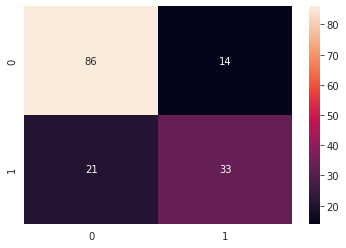

In [ ]:
# Heatmap of Confusion matrix
sns.heatmap(pd.DataFrame(cm), annot=True)

In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83       100
         1.0       0.70      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154



In [ ]:
for i in [Y_pred_logreg, Y_pred_knn, Y_pred_svc, Y_pred_nb, Y_pred_dectree, Y_pred_ranfor]:
  cm = confusion_matrix(Y_test, i)
  
  cm_TP = cm[0][0]
  cm_TN = cm[1][1]
  cm_FP = cm[0][1]
  cm_FN = cm[1][0]

  recall = cm_TP/(cm_TP+cm_FN)
  precision = cm_TP/(cm_TP+cm_FP)

  print(classification_report(Y_test, i))
  print('Recall -> {0}, Precision -> {1}, F1-Score -> {2}'.format(recall, precision, 2*(recall*precision)/(recall + precision)))
  print('-'*50)

              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80       100
         1.0       0.64      0.52      0.57        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154

Recall -> 0.7636363636363637, Precision -> 0.84, F1-Score -> 0.8000000000000002
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83       100
         1.0       0.70      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154

Recall -> 0.8037383177570093, Precision -> 0.86, F1-Score -> 0.8309178743961353
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.76      